# 노드에 나온 대로 설계
#### epochs만 20으로 바꿈

## 1. 패키지 로딩하기

In [2]:
from sklearn.model_selection import train_test_split # 데이터 전처리에 필요한 패키지

import os                                            # I/O 관련된 작업에 필요한 패키지
import re                                            # 정규표현식 관련된 작업에 필요한 패키지
import numpy as np                                   # 데이터 array 작업에 필요한 패키지
import pandas as pd                                  # 데이터 전처리 관련된 작업에 필요한 패키지
import tensorflow as tf                              # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt                      # 데이터 시각화에 관련된 작업에 필요한 패키지

## 2. 앞으로 필요한 변수 생성하기
#### BATCH_SIZE, EPOCHS 정도 하이퍼 파라미터는 바꿀 수 있을 듯 하다.

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH  = os.path.join(os.getenv("HOME"), "aiffel")

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS     = 20

print(ROOT_PATH)

/home/aiffel-dj52/aiffel


## 3. 데이터 준비하기

In [3]:
# tf.io.gfile.glob을 쓰면 주어진 패턴과 일치하는 파일 목록을 반환한다.
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*/*")) # train 폴더에 있는 모든 파일을 지정
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/test/*/*"))  # test  폴더에 있는 모든 파일을 지정
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*"))   # val   폴더에 있는 모든 파일을 지정

print("train data len :", len(train_filenames))                              # train data 길이 출력
print("test data len :",  len(test_filenames))                               # test  data 길이 출력
print("val data len :",   len(val_filenames))                                # val data 길이 출력

train data len : 5216
test data len : 624
val data len : 16


In [4]:
# validation 데이터가 train data에 비해 너무 적어서 trian data와 validation data를 합치고 8:2 비율로 나눠준다.
filenames = tf.io.gfile.glob(str(ROOT_PATH      + "/chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*")))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%를 의미한다.
train_filenames, val_filenames = train_test_split(filenames, test_size = 0.2)

print("train data len :", len(train_filenames))
print("val data len :",   len(val_filenames))
print("test data len :",  len(test_filenames))

train data len : 4185
val data len : 1047
test data len : 624


In [5]:
COUNT_NORMAL    = len([filename for filename in train_filenames if "NORMAL" in filename])    # train_filenames 중 NORMAL만 찾아서 길이 재기
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) # train_filenames 중 PNEUMONIA만 찾아서 길이 재기

print("Normal images count in training set :"    + str(COUNT_NORMAL))
print("Pneumonia images count in training set :" + str(COUNT_PNEUMONIA))

Normal images count in training set :1080
Pneumonia images count in training set :3105


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # train_filenames를 텐서조각을 가진 데이터셋으로 만듬
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)   # val_filenames를 텐서조각을 가진 데이터셋으로 만듬

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # train_list_ds의 데이터셋 갯수를 센다.
VAL_IMG_COUNT   = tf.data.experimental.cardinality(val_list_ds).numpy()   # val_list_ds의 데이터셋 갯수를 센다.

print("Training images count :"   + str(TRAIN_IMG_COUNT))
print("Validating images count :" + str(VAL_IMG_COUNT))

Training images count :4185
Validating images count :1047


In [8]:
tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))

['/home/aiffel-dj52/aiffel/chest_xray/train/NORMAL',
 '/home/aiffel-dj52/aiffel/chest_xray/train/PNEUMONIA']

In [9]:
# 라벨 확인하기 -> 위에 나온 2개 리스트를 for문으로 돌려서 "/"로 구분해서 맨 뒤에 나온 것을 변수에 저장한다.
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [4]:
# 불러올 이미지에 라벨을 붙여주는 함수 만들기
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 정상(노멀)이면 음성(False)를 리턴하게 한다.

In [5]:
# 이미지 파일을 이것저것 변환하는 함수 만들기
def decode_img(img):
    #이미지를 uint8 tensor로 바꾼다.
    img = tf.image.decode_jpeg(img, channels = 3)
    
    # img를 범위 [0, 1]의 float32 데이터 타입으로 바꾼다.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
    return tf.image.resize(img, IMAGE_SIZE)

# 파일의 라벨을 만들고 읽어온 뒤 이것저것 변환하는 함수를 만들기
def process_path(file_path):
    label = get_label(file_path)       # 파일의 라벨을 저장한다.
    img   = tf.io.read_file(file_path) # 파일을 읽어온다.
    img   = decode_img(img)            # 읽어온 파일을 이것저것 변환한다.
    return img, label

In [12]:
# train dataset과 validation dataset 만들기 (num_parallel_calls에 위에서 초기화한 AUTOTUNE을 넣어주면 더 빠르게 진행할 수 있다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

In [13]:
# 위에 코드가 잘 작동했는지 확인하기
for image, label in train_ds.take(3): # train_ds에서 3개의 파일만 가져온다.
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy())

Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : False


In [14]:
# train과 val이 한 것과 동일하게 test에도 해준다.
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/chest_xray/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
# 데이터를 효율적으로 학습할 수 있게 변환해주는 함수 만들기
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    # shuffle()을 사용하면 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    # repeat()을 사용하면 사용한 데이터셋을 여러번 사용할 수 있다.
    ds = ds.repeat()
    
    # batch()을 사용하면 BATCH_SIZE에서 지정한 만큼 배치로 주어진다.
    ds = ds.batch(BATCH_SIZE)
    
    # prefetch()을 사용하면 학습데이터를 나눠서 읽어오기 때문에, GPU가 첫 번째 데이터를 학습하는 동안 CPU가 두 번째 데이터를 준비할 수 있다.
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

# train과 val에 함수 적용하기
train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

##  4. 데이터 시각화 하기

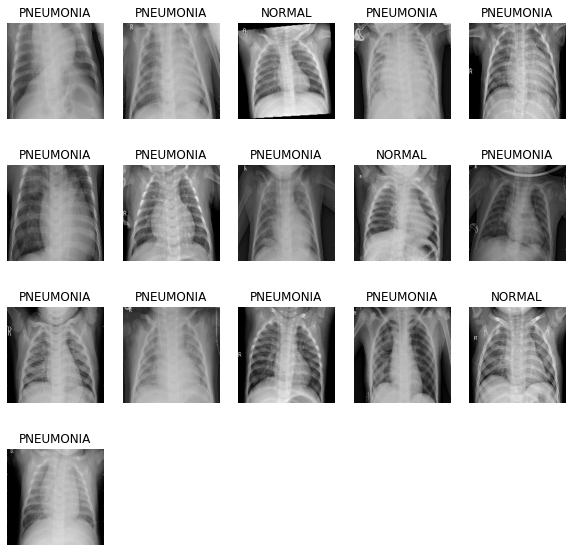

In [16]:
image_batch, label_batch = next(iter(train_ds)) # train에서 첫 번째 배치를 추출하고 image, label를 나누고 다음 배치를 추출한다.

# 데이터를 보여주는 함수 만들기
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))              # 데이터 크기 지정
    for n in range(16):                         # 16개만 출력해보기
        ax = plt.subplot(4, 5, n + 1)           # 각 그림들 위치 지정하기
        plt.imshow(image_batch[n])              # 해당 이미지를 출력한다.
        if label_batch[n]:                      # 만약 label이 true이면
            plt.title("PNEUMONIA")              # 제목을 페렴으로 하고
        else:                                   # 그렇지 않으면
            plt.title("NORMAL")                 # 제목을 정상으로 한다.
        plt.axis("off")                         # 불필요한 축은 출력하지 않는다.
        
show_batch(image_batch.numpy(), label_batch.numpy())

## 5. CNN 모델링
#### 모델 설계를 바꿔서 하면 결과가 달라질 수 있을 듯 하다

In [18]:
# conv 구조 모델링 하는 함수 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = "relu", padding = "same"), # conv층 설계
        tf.keras.layers.SeparableConv2D(filters, 3, activation = "relu", padding = "same"), # conv층 설계
        tf.keras.layers.BatchNormalization(),                                               # Normalization
        tf.keras.layers.MaxPool2D()                                                         # MaxPooling
    ])
    
    return block

In [19]:
# dense 구조 모델링 하는 함수 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = "relu"), # dense 층 설계
        tf.keras.layers.BatchNormalization(),              # Normalization
        tf.keras.layers.Dropout(dropout_rate)              # Dropout
    ])
    
    return block
# 여기서는 재밌게도 BatchNormalization과 Dropout을 같이 썼다.
# 이는 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다.

In [20]:
# model을 만드는 함수 만들기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),            # Input 사이즈 지정하기
        
        tf.keras.layers.Conv2D(16, 3, activation = "relu", padding = "same"), # Conv2D 층 설계
        tf.keras.layers.Conv2D(16, 3, activation = "relu", padding = "same"), # Conv2D 층 설계
        
        conv_block(32),                                                       # conv층 설계
        conv_block(64),                                                       # conv층 설계
        
        conv_block(128),                                                      # conv층 설계
        tf.keras.layers.Dropout(0.2),                                         # 0.2비율로 Dropout
        
        conv_block(256),                                                      # conv층 설계
        tf.keras.layers.Dropout(0.2),                                         # 0.2비율로 Dropout
        
        tf.keras.layers.Flatten(),                                            # 선형화
        dense_block(512, 0.7),                                                # dense 층 설계 (Dropout을 0.7 비율로 하고)
        dense_block(128, 0.5),                                                # dense 층 설계 (Dropout을 0.5 비율로 하고)
        dense_block(64,  0.3),                                                # dense 층 설계 (Dropout을 0.3 비율로 하고)
        
        tf.keras.layers.Dense(1, activation = "sigmoid")                      # 이진 분류 마무리 층 설계
    ])
    
    return model

## 6. 데이터 imbalance 처리

In [20]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0    # Normal    이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 # Pneumonia 이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}              # dict 만들기

print("Weight for class 0 : {:.2f}".format(weight_for_0))
print("Weight for class 1 : {:.2f}".format(weight_for_1))

Weight for class 0 : 1.94
Weight for class 1 : 0.67


## 7. 모델 훈련

In [21]:
# optimizer, learning rate 정도는 바꿔도 좋을 듯 하다.
with tf.device("/GPU:0"):
    model = build_model()
    
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall")
    ]
    
    model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy", # 이진 분류 이므로 바이너리를 쓴다.
        metrics   = METRICS                # 평가지표는 위에 설정한 3개로 한다.
    )

In [22]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight     = class_weight
    )

Epoch 1/20
261/261 [==============================] - 52s 197ms/step - loss: 0.3420 - accuracy: 0.8436 - precision: 0.9608 - recall: 0.8228 - val_loss: 0.6402 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 46s 177ms/step - loss: 0.2496 - accuracy: 0.9009 - precision: 0.9685 - recall: 0.8953 - val_loss: 0.9981 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 47s 180ms/step - loss: 0.1750 - accuracy: 0.9313 - precision: 0.9789 - recall: 0.9275 - val_loss: 0.3697 - val_accuracy: 0.8106 - val_precision: 0.7969 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 44s 169ms/step - loss: 0.1774 - accuracy: 0.9318 - precision: 0.9779 - recall: 0.9290 - val_loss: 0.2450 - val_accuracy: 0.9000 - val_precision: 0.9985 - val_recall: 0.8666
Epoch 5/20
261/261 [==============================] - 51s 194ms/step - loss: 0.1666 - accura

## 7. 결과 확인

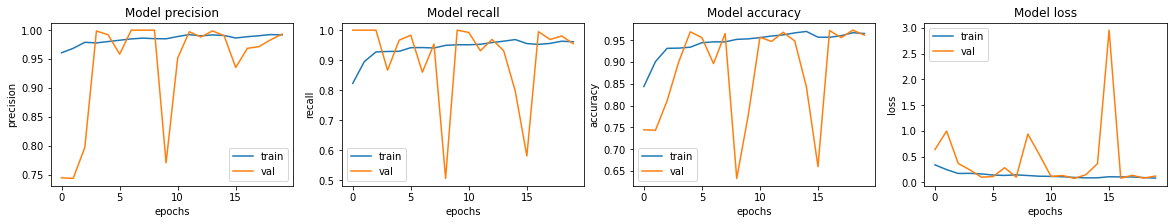

In [23]:
# 훈련 과정 시각화하기
# accuracy도 중요하지만 의료영상 특성상 recall도 중요한 지표이다.
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## 8. 모델 평가

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 0.5618 - accuracy: 0.8686 - precision: 0.8392 - recall: 0.9769


# data augmentation를 이용하여 데이터 반전 사진 추가하여 실습

## 1. 데이터 준비하기

In [6]:
# tf.io.gfile.glob을 쓰면 주어진 패턴과 일치하는 파일 목록을 반환한다.
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*/*")) # train 폴더에 있는 모든 파일을 지정
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/test/*/*"))  # test  폴더에 있는 모든 파일을 지정
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*"))   # val   폴더에 있는 모든 파일을 지정

print("train data len :", len(train_filenames))                              # train data 길이 출력
print("test data len :",  len(test_filenames))                               # test  data 길이 출력
print("val data len :",   len(val_filenames))                                # val data 길이 출력

train data len : 5216
test data len : 624
val data len : 16


In [7]:
# validation 데이터가 train data에 비해 너무 적어서 trian data와 validation data를 합치고 8:2 비율로 나눠준다.
filenames = tf.io.gfile.glob(str(ROOT_PATH      + "/chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*")))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%를 의미한다.
train_filenames, val_filenames = train_test_split(filenames, test_size = 0.2)

print("train data len :", len(train_filenames))
print("val data len :",   len(val_filenames))
print("test data len :",  len(test_filenames))

train data len : 4185
val data len : 1047
test data len : 624


In [8]:
COUNT_NORMAL    = len([filename for filename in train_filenames if "NORMAL" in filename])    # train_filenames 중 NORMAL만 찾아서 길이 재기
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) # train_filenames 중 PNEUMONIA만 찾아서 길이 재기

print("Normal images count in training set :"    + str(COUNT_NORMAL))
print("Pneumonia images count in training set :" + str(COUNT_PNEUMONIA))

Normal images count in training set :1061
Pneumonia images count in training set :3124


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # train_filenames를 텐서조각을 가진 데이터셋으로 만듬
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)   # val_filenames를 텐서조각을 가진 데이터셋으로 만듬

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # train_list_ds의 데이터셋 갯수를 센다.
VAL_IMG_COUNT   = tf.data.experimental.cardinality(val_list_ds).numpy()   # val_list_ds의 데이터셋 갯수를 센다.

print("Training images count :"   + str(TRAIN_IMG_COUNT))
print("Validating images count :" + str(VAL_IMG_COUNT))

Training images count :4185
Validating images count :1047


In [11]:
tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))

['/home/aiffel-dj52/aiffel/chest_xray/train/NORMAL',
 '/home/aiffel-dj52/aiffel/chest_xray/train/PNEUMONIA']

In [12]:
# 라벨 확인하기 -> 위에 나온 2개 리스트를 for문으로 돌려서 "/"로 구분해서 맨 뒤에 나온 것을 변수에 저장한다.
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [13]:
# train dataset과 validation dataset 만들기 (num_parallel_calls에 위에서 초기화한 AUTOTUNE을 넣어주면 더 빠르게 진행할 수 있다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

In [14]:
# 위에 코드가 잘 작동했는지 확인하기
for image, label in train_ds.take(3): # train_ds에서 3개의 파일만 가져온다.
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy())

Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : False
Image shape : (180, 180, 3)
Label : True


In [15]:
# train과 val이 한 것과 동일하게 test에도 해준다.
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/chest_xray/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 이 부분이 바뀜

In [16]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전한다.
    return image, label

# 데이터를 효율적으로 학습할 수 있게 변환해주는 함수 만들기
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    # augment 적용 부분이 배치처리 함수에 추가되었다.
    ds = ds.map(augment, num_parallel_calls = 2)
    
    # shuffle()을 사용하면 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    # repeat()을 사용하면 사용한 데이터셋을 여러번 사용할 수 있다.
    ds = ds.repeat()
    
    # batch()을 사용하면 BATCH_SIZE에서 지정한 만큼 배치로 주어진다.
    ds = ds.batch(BATCH_SIZE)
    
    # prefetch()을 사용하면 학습데이터를 나눠서 읽어오기 때문에, GPU가 첫 번째 데이터를 학습하는 동안 CPU가 두 번째 데이터를 준비할 수 있다.
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

# train과 val에 함수 적용하기
train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

##  2. 데이터 시각화 하기

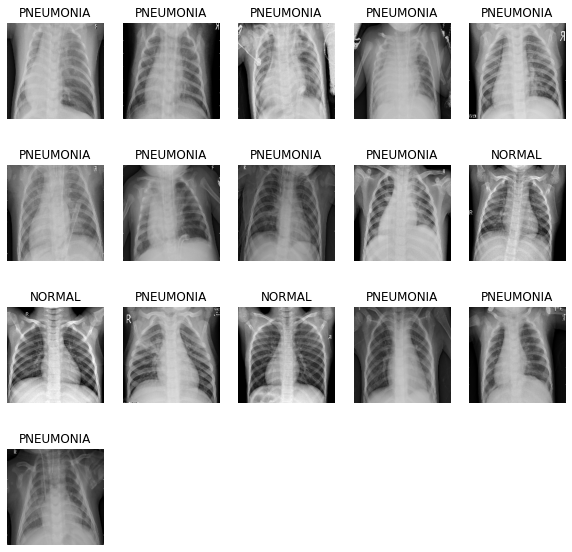

In [17]:
image_batch, label_batch = next(iter(train_ds)) # train에서 첫 번째 배치를 추출하고 image, label를 나누고 다음 배치를 추출한다.

# 데이터를 보여주는 함수 만들기
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))              # 데이터 크기 지정
    for n in range(16):                         # 16개만 출력해보기
        ax = plt.subplot(4, 5, n + 1)           # 각 그림들 위치 지정하기
        plt.imshow(image_batch[n])              # 해당 이미지를 출력한다.
        if label_batch[n]:                      # 만약 label이 true이면
            plt.title("PNEUMONIA")              # 제목을 페렴으로 하고
        else:                                   # 그렇지 않으면
            plt.title("NORMAL")                 # 제목을 정상으로 한다.
        plt.axis("off")                         # 불필요한 축은 출력하지 않는다.
        
show_batch(image_batch.numpy(), label_batch.numpy())

## 3. CNN 모델링
#### 모델 설계를 바꿔서 하면 결과가 달라질 수 있을 듯 하다

In [21]:
# 이는 위에서 이미 했으므로 패스

## 4. 데이터 imbalance 처리

In [22]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0    # Normal    이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 # Pneumonia 이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}              # dict 만들기

print("Weight for class 0 : {:.2f}".format(weight_for_0))
print("Weight for class 1 : {:.2f}".format(weight_for_1))

Weight for class 0 : 1.97
Weight for class 1 : 0.67


## 5. 모델 훈련

In [23]:
# optimizer, learning rate 정도는 바꿔도 좋을 듯 하다.
with tf.device("/GPU:0"):
    model = build_model()
    
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall")
    ]
    
    model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy", # 이진 분류 이므로 바이너리를 쓴다.
        metrics   = METRICS                # 평가지표는 위에 설정한 3개로 한다.
    )

In [24]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight     = class_weight
    )

Epoch 1/20
261/261 [==============================] - 54s 207ms/step - loss: 0.3604 - accuracy: 0.8288 - precision: 0.9570 - recall: 0.8069 - val_loss: 0.9595 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 45s 174ms/step - loss: 0.2378 - accuracy: 0.9092 - precision: 0.9744 - recall: 0.9021 - val_loss: 1.5688 - val_accuracy: 0.7240 - val_precision: 0.7240 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 52s 200ms/step - loss: 0.2032 - accuracy: 0.9210 - precision: 0.9732 - recall: 0.9195 - val_loss: 0.1160 - val_accuracy: 0.9538 - val_precision: 0.9596 - val_recall: 0.9775
Epoch 4/20
261/261 [==============================] - 47s 179ms/step - loss: 0.1753 - accuracy: 0.9258 - precision: 0.9795 - recall: 0.9198 - val_loss: 0.5267 - val_accuracy: 0.8212 - val_precision: 1.0000 - val_recall: 0.7527
Epoch 5/20
261/261 [==============================] - 53s 203ms/step - loss: 0.1748 - accura

## 6. 결과 확인

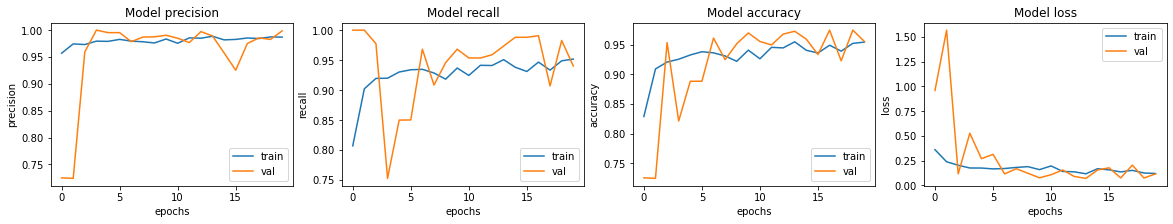

In [25]:
# 훈련 과정 시각화하기
# accuracy도 중요하지만 의료영상 특성상 recall도 중요한 지표이다.
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## 7. 모델 평가

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.5373 - accuracy: 0.8558 - precision: 0.8219 - recall: 0.9821


# augment를 사용하지 않은 노드의 설계, epochs를 100으로 설정하여 실습

## 1. 데이터 준비하기

In [112]:
# tf.io.gfile.glob을 쓰면 주어진 패턴과 일치하는 파일 목록을 반환한다.
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*/*")) # train 폴더에 있는 모든 파일을 지정
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/test/*/*"))  # test  폴더에 있는 모든 파일을 지정
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*"))   # val   폴더에 있는 모든 파일을 지정

print("train data len :", len(train_filenames))                              # train data 길이 출력
print("test data len :",  len(test_filenames))                               # test  data 길이 출력
print("val data len :",   len(val_filenames))                                # val data 길이 출력

train data len : 5216
test data len : 624
val data len : 16


In [113]:
# validation 데이터가 train data에 비해 너무 적어서 trian data와 validation data를 합치고 8:2 비율로 나눠준다.
filenames = tf.io.gfile.glob(str(ROOT_PATH      + "/chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*")))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%를 의미한다.
train_filenames, val_filenames = train_test_split(filenames, test_size = 0.2)

print("train data len :", len(train_filenames))
print("val data len :",   len(val_filenames))
print("test data len :",  len(test_filenames))

train data len : 4185
val data len : 1047
test data len : 624


In [114]:
COUNT_NORMAL    = len([filename for filename in train_filenames if "NORMAL" in filename])    # train_filenames 중 NORMAL만 찾아서 길이 재기
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) # train_filenames 중 PNEUMONIA만 찾아서 길이 재기

print("Normal images count in training set :"    + str(COUNT_NORMAL))
print("Pneumonia images count in training set :" + str(COUNT_PNEUMONIA))

Normal images count in training set :1078
Pneumonia images count in training set :3107


In [115]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # train_filenames를 텐서조각을 가진 데이터셋으로 만듬
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)   # val_filenames를 텐서조각을 가진 데이터셋으로 만듬

In [116]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # train_list_ds의 데이터셋 갯수를 센다.
VAL_IMG_COUNT   = tf.data.experimental.cardinality(val_list_ds).numpy()   # val_list_ds의 데이터셋 갯수를 센다.

print("Training images count :"   + str(TRAIN_IMG_COUNT))
print("Validating images count :" + str(VAL_IMG_COUNT))

Training images count :4185
Validating images count :1047


In [117]:
tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))

['/home/aiffel-dj52/aiffel/chest_xray/train/NORMAL',
 '/home/aiffel-dj52/aiffel/chest_xray/train/PNEUMONIA']

In [118]:
# 라벨 확인하기 -> 위에 나온 2개 리스트를 for문으로 돌려서 "/"로 구분해서 맨 뒤에 나온 것을 변수에 저장한다.
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [119]:
# train dataset과 validation dataset 만들기 (num_parallel_calls에 위에서 초기화한 AUTOTUNE을 넣어주면 더 빠르게 진행할 수 있다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

In [120]:
# 위에 코드가 잘 작동했는지 확인하기
for image, label in train_ds.take(3): # train_ds에서 3개의 파일만 가져온다.
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy())

Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : True


In [121]:
# train과 val이 한 것과 동일하게 test에도 해준다.
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/chest_xray/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [122]:
# 데이터를 효율적으로 학습할 수 있게 변환해주는 함수 만들기
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    # shuffle()을 사용하면 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    # repeat()을 사용하면 사용한 데이터셋을 여러번 사용할 수 있다.
    ds = ds.repeat()
    
    # batch()을 사용하면 BATCH_SIZE에서 지정한 만큼 배치로 주어진다.
    ds = ds.batch(BATCH_SIZE)
    
    # prefetch()을 사용하면 학습데이터를 나눠서 읽어오기 때문에, GPU가 첫 번째 데이터를 학습하는 동안 CPU가 두 번째 데이터를 준비할 수 있다.
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

# train과 val에 함수 적용하기
train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

##  2. 데이터 시각화 하기

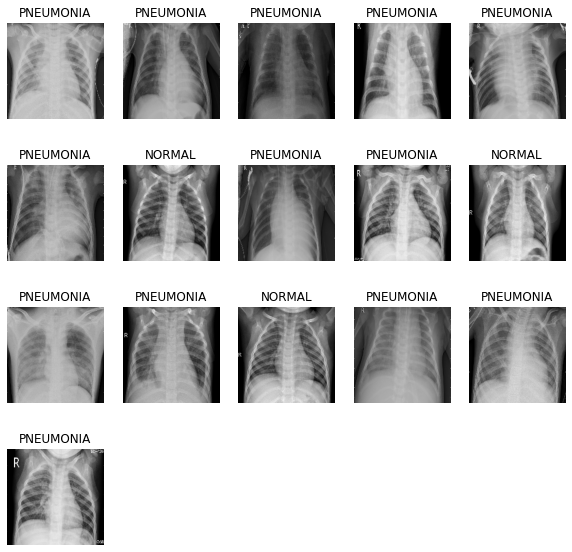

In [123]:
image_batch, label_batch = next(iter(train_ds)) # train에서 첫 번째 배치를 추출하고 image, label를 나누고 다음 배치를 추출한다.

# 데이터를 보여주는 함수 만들기
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))              # 데이터 크기 지정
    for n in range(16):                         # 16개만 출력해보기
        ax = plt.subplot(4, 5, n + 1)           # 각 그림들 위치 지정하기
        plt.imshow(image_batch[n])              # 해당 이미지를 출력한다.
        if label_batch[n]:                      # 만약 label이 true이면
            plt.title("PNEUMONIA")              # 제목을 페렴으로 하고
        else:                                   # 그렇지 않으면
            plt.title("NORMAL")                 # 제목을 정상으로 한다.
        plt.axis("off")                         # 불필요한 축은 출력하지 않는다.
        
show_batch(image_batch.numpy(), label_batch.numpy())

## 3. CNN 모델링
#### 모델 설계를 바꿔서 하면 결과가 달라질 수 있을 듯 하다

In [124]:
# 이는 위에서 이미 했으므로 패스

## 4. 데이터 imbalance 처리

In [125]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0    # Normal    이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 # Pneumonia 이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}              # dict 만들기

print("Weight for class 0 : {:.2f}".format(weight_for_0))
print("Weight for class 1 : {:.2f}".format(weight_for_1))

Weight for class 0 : 1.94
Weight for class 1 : 0.67


## 5. 모델 훈련

In [126]:
EPOCHS = 50

In [127]:
# optimizer, learning rate 정도는 바꿔도 좋을 듯 하다.
with tf.device("/GPU:0"):
    model = build_model()
    
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall")
    ]
    
    model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy", # 이진 분류 이므로 바이너리를 쓴다.
        metrics   = METRICS                # 평가지표는 위에 설정한 3개로 한다.
    )

In [128]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight     = class_weight
    )

Epoch 1/50
261/261 [==============================] - 46s 177ms/step - loss: 0.3854 - accuracy: 0.8103 - precision: 0.9540 - recall: 0.7824 - val_loss: 0.7215 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 44s 169ms/step - loss: 0.2110 - accuracy: 0.9210 - precision: 0.9746 - recall: 0.9174 - val_loss: 1.5788 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 51s 195ms/step - loss: 0.1915 - accuracy: 0.9248 - precision: 0.9771 - recall: 0.9204 - val_loss: 0.2387 - val_accuracy: 0.8942 - val_precision: 0.8751 - val_recall: 1.0000
Epoch 4/50
261/261 [==============================] - 44s 167ms/step - loss: 0.1721 - accuracy: 0.9380 - precision: 0.9804 - recall: 0.9353 - val_loss: 0.1454 - val_accuracy: 0.9538 - val_precision: 0.9932 - val_recall: 0.9442
Epoch 5/50
261/261 [==============================] - 50s 192ms/step - loss: 0.1512 - accura

Epoch 37/50
261/261 [==============================] - 46s 175ms/step - loss: 0.0300 - accuracy: 0.9897 - precision: 0.9968 - recall: 0.9894 - val_loss: 0.0577 - val_accuracy: 0.9817 - val_precision: 0.9934 - val_recall: 0.9818
Epoch 38/50
261/261 [==============================] - 44s 170ms/step - loss: 0.0276 - accuracy: 0.9899 - precision: 0.9977 - recall: 0.9887 - val_loss: 0.0569 - val_accuracy: 0.9827 - val_precision: 0.9922 - val_recall: 0.9845
Epoch 39/50
261/261 [==============================] - 45s 171ms/step - loss: 0.0385 - accuracy: 0.9856 - precision: 0.9957 - recall: 0.9848 - val_loss: 0.1550 - val_accuracy: 0.9702 - val_precision: 0.9933 - val_recall: 0.9663
Epoch 40/50
261/261 [==============================] - 46s 175ms/step - loss: 0.0409 - accuracy: 0.9861 - precision: 0.9971 - recall: 0.9842 - val_loss: 0.0600 - val_accuracy: 0.9798 - val_precision: 0.9934 - val_recall: 0.9792
Epoch 41/50
261/261 [==============================] - 46s 175ms/step - loss: 0.0217 - a

## 6. 결과 확인

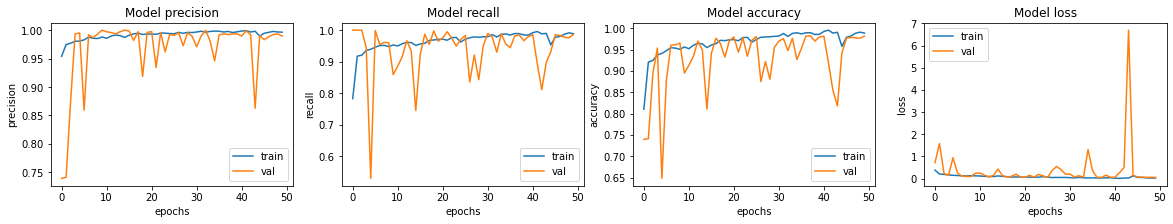

In [129]:
# 훈련 과정 시각화하기
# accuracy도 중요하지만 의료영상 특성상 recall도 중요한 지표이다.
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## 7. 모델 평가

In [130]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 2.2807 - accuracy: 0.7564 - precision: 0.7212 - recall: 0.9949


# augment를 사용하고, epochs를 100으로 설정하여 실습

## 1. 데이터 준비하기

In [131]:
# tf.io.gfile.glob을 쓰면 주어진 패턴과 일치하는 파일 목록을 반환한다.
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*/*")) # train 폴더에 있는 모든 파일을 지정
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/test/*/*"))  # test  폴더에 있는 모든 파일을 지정
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*"))   # val   폴더에 있는 모든 파일을 지정

print("train data len :", len(train_filenames))                              # train data 길이 출력
print("test data len :",  len(test_filenames))                               # test  data 길이 출력
print("val data len :",   len(val_filenames))                                # val data 길이 출력

train data len : 5216
test data len : 624
val data len : 16


In [132]:
# validation 데이터가 train data에 비해 너무 적어서 trian data와 validation data를 합치고 8:2 비율로 나눠준다.
filenames = tf.io.gfile.glob(str(ROOT_PATH      + "/chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/val/*/*")))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%를 의미한다.
train_filenames, val_filenames = train_test_split(filenames, test_size = 0.2)

print("train data len :", len(train_filenames))
print("val data len :",   len(val_filenames))
print("test data len :",  len(test_filenames))

train data len : 4185
val data len : 1047
test data len : 624


In [133]:
COUNT_NORMAL    = len([filename for filename in train_filenames if "NORMAL" in filename])    # train_filenames 중 NORMAL만 찾아서 길이 재기
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) # train_filenames 중 PNEUMONIA만 찾아서 길이 재기

print("Normal images count in training set :"    + str(COUNT_NORMAL))
print("Pneumonia images count in training set :" + str(COUNT_PNEUMONIA))

Normal images count in training set :1106
Pneumonia images count in training set :3079


In [134]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # train_filenames를 텐서조각을 가진 데이터셋으로 만듬
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)   # val_filenames를 텐서조각을 가진 데이터셋으로 만듬

In [135]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # train_list_ds의 데이터셋 갯수를 센다.
VAL_IMG_COUNT   = tf.data.experimental.cardinality(val_list_ds).numpy()   # val_list_ds의 데이터셋 갯수를 센다.

print("Training images count :"   + str(TRAIN_IMG_COUNT))
print("Validating images count :" + str(VAL_IMG_COUNT))

Training images count :4185
Validating images count :1047


In [136]:
tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))

['/home/aiffel-dj52/aiffel/chest_xray/train/NORMAL',
 '/home/aiffel-dj52/aiffel/chest_xray/train/PNEUMONIA']

In [137]:
# 라벨 확인하기 -> 위에 나온 2개 리스트를 for문으로 돌려서 "/"로 구분해서 맨 뒤에 나온 것을 변수에 저장한다.
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [138]:
# train dataset과 validation dataset 만들기 (num_parallel_calls에 위에서 초기화한 AUTOTUNE을 넣어주면 더 빠르게 진행할 수 있다.)
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

In [139]:
# 위에 코드가 잘 작동했는지 확인하기
for image, label in train_ds.take(3): # train_ds에서 3개의 파일만 가져온다.
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy())

Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : True
Image shape : (180, 180, 3)
Label : True


In [140]:
# train과 val이 한 것과 동일하게 test에도 해준다.
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/chest_xray/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [141]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전한다.
    return image, label

# 데이터를 효율적으로 학습할 수 있게 변환해주는 함수 만들기
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    # augment 적용 부분이 배치처리 함수에 추가되었다.
    ds = ds.map(augment, num_parallel_calls = 2)
    
    # shuffle()을 사용하면 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    # repeat()을 사용하면 사용한 데이터셋을 여러번 사용할 수 있다.
    ds = ds.repeat()
    
    # batch()을 사용하면 BATCH_SIZE에서 지정한 만큼 배치로 주어진다.
    ds = ds.batch(BATCH_SIZE)
    
    # prefetch()을 사용하면 학습데이터를 나눠서 읽어오기 때문에, GPU가 첫 번째 데이터를 학습하는 동안 CPU가 두 번째 데이터를 준비할 수 있다.
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

# train과 val에 함수 적용하기
train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

##  2. 데이터 시각화 하기

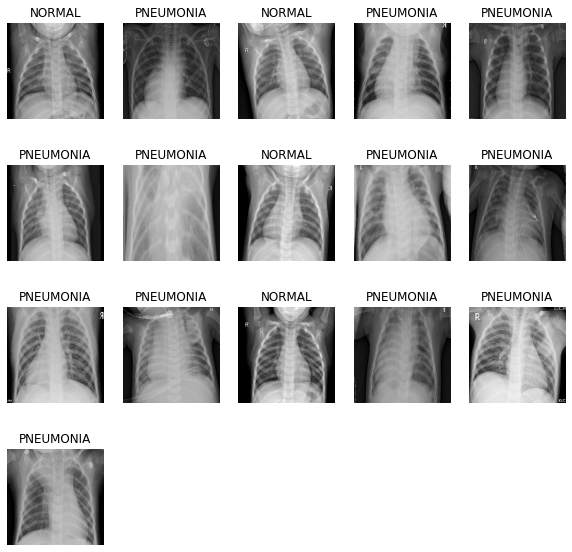

In [142]:
image_batch, label_batch = next(iter(train_ds)) # train에서 첫 번째 배치를 추출하고 image, label를 나누고 다음 배치를 추출한다.

# 데이터를 보여주는 함수 만들기
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))              # 데이터 크기 지정
    for n in range(16):                         # 16개만 출력해보기
        ax = plt.subplot(4, 5, n + 1)           # 각 그림들 위치 지정하기
        plt.imshow(image_batch[n])              # 해당 이미지를 출력한다.
        if label_batch[n]:                      # 만약 label이 true이면
            plt.title("PNEUMONIA")              # 제목을 페렴으로 하고
        else:                                   # 그렇지 않으면
            plt.title("NORMAL")                 # 제목을 정상으로 한다.
        plt.axis("off")                         # 불필요한 축은 출력하지 않는다.
        
show_batch(image_batch.numpy(), label_batch.numpy())

## 3. CNN 모델링
#### 모델 설계를 바꿔서 하면 결과가 달라질 수 있을 듯 하다

In [143]:
# 이는 위에서 이미 했으므로 패스

## 4. 데이터 imbalance 처리

In [144]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0    # Normal    이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 # Pneumonia 이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}              # dict 만들기

print("Weight for class 0 : {:.2f}".format(weight_for_0))
print("Weight for class 1 : {:.2f}".format(weight_for_1))

Weight for class 0 : 1.89
Weight for class 1 : 0.68


## 5. 모델 훈련

In [145]:
EPOCHS = 50

In [146]:
# optimizer, learning rate 정도는 바꿔도 좋을 듯 하다.
with tf.device("/GPU:0"):
    model = build_model()
    
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name = "recall")
    ]
    
    model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy", # 이진 분류 이므로 바이너리를 쓴다.
        metrics   = METRICS                # 평가지표는 위에 설정한 3개로 한다.
    )

In [147]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight     = class_weight
    )

Epoch 1/50
261/261 [==============================] - 45s 173ms/step - loss: 0.3750 - accuracy: 0.8206 - precision: 0.9514 - recall: 0.7968 - val_loss: 0.6704 - val_accuracy: 0.7663 - val_precision: 0.7663 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 46s 176ms/step - loss: 0.2547 - accuracy: 0.8992 - precision: 0.9689 - recall: 0.8916 - val_loss: 1.4364 - val_accuracy: 0.7673 - val_precision: 0.7673 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 46s 175ms/step - loss: 0.1961 - accuracy: 0.9195 - precision: 0.9724 - recall: 0.9168 - val_loss: 0.1900 - val_accuracy: 0.9192 - val_precision: 0.9076 - val_recall: 0.9962
Epoch 4/50
261/261 [==============================] - 42s 163ms/step - loss: 0.1868 - accuracy: 0.9303 - precision: 0.9763 - recall: 0.9276 - val_loss: 0.2004 - val_accuracy: 0.9087 - val_precision: 0.8946 - val_recall: 0.9987
Epoch 5/50
261/261 [==============================] - 49s 187ms/step - loss: 0.1604 - accura

Epoch 37/50
261/261 [==============================] - 44s 170ms/step - loss: 0.0617 - accuracy: 0.9741 - precision: 0.9953 - recall: 0.9695 - val_loss: 0.0987 - val_accuracy: 0.9596 - val_precision: 0.9961 - val_recall: 0.9511
Epoch 38/50
261/261 [==============================] - 45s 171ms/step - loss: 0.0641 - accuracy: 0.9756 - precision: 0.9933 - recall: 0.9732 - val_loss: 0.0612 - val_accuracy: 0.9779 - val_precision: 0.9962 - val_recall: 0.9749
Epoch 39/50
261/261 [==============================] - 45s 173ms/step - loss: 0.0564 - accuracy: 0.9777 - precision: 0.9963 - recall: 0.9732 - val_loss: 0.1433 - val_accuracy: 0.9490 - val_precision: 1.0000 - val_recall: 0.9336
Epoch 40/50
261/261 [==============================] - 45s 172ms/step - loss: 0.0588 - accuracy: 0.9768 - precision: 0.9941 - recall: 0.9744 - val_loss: 0.2066 - val_accuracy: 0.9548 - val_precision: 0.9487 - val_recall: 0.9950
Epoch 41/50
261/261 [==============================] - 45s 171ms/step - loss: 0.0631 - a

## 6. 결과 확인

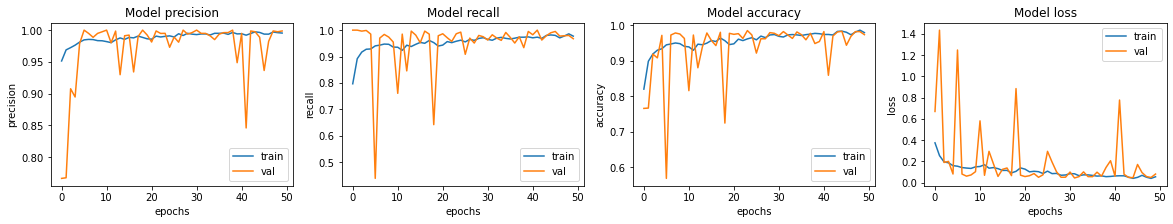

In [148]:
# 훈련 과정 시각화하기
# accuracy도 중요하지만 의료영상 특성상 recall도 중요한 지표이다.
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## 7. 모델 평가

In [149]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 54ms/step - loss: 1.3711 - accuracy: 0.8317 - precision: 0.8065 - recall: 0.9615


# 회고록

In [ ]:
# 오늘 노드는 비교적 따라하기 쉬웠던 것 같다.
# 아마 이전에 이미 데이터 전처리, CNN에 대해 배웠고, keras의 모델링 3가지의 방법을 이미 배워서 그런 듯 하다.
# 다만 응용이 까다로웠다. epochs 같이 그냥 바꾸기만 하면 되는 하이퍼 파라미터는 손쉽게 하지만, 
# batch size나 CNN 모델 설계와 같은 계산이 좀 필요한 것 같은 경우에는 쉽사리 손대기가 꺼려졌다.
# 이미 처음에 batch size를 64로 건드렸다가 오류가 나서 노드에 나온대로 다시 바꾸었다.
# 모델을 2차례 돌리는 동안 운이 좋게도 accuracy가 85%이상이 나와서 호기심에 epochs를 100까지 하여 시간이 되는 한 최대한 과적합을 시켜봤다.
# 결과는 두 모델 다 75% 정도였다.
# 그래프를 보니 epochs 50정도에서 먼가 변화가 크게 보여서 이번에는 epochs 50을 주고 다시 모델을 돌렸다. (때문에 epochs 100의 결과물이 사라짐.)
# epochs 50이여도 별 다른 좋은 성과는 없었다.